In [18]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams['font.family'] = 'SimHei'      # 中文支持
plt.rcParams['axes.unicode_minus'] = False  # 负号显示

def plot_gantt_from_log(log_json_path, save_path=None):
    with open(log_json_path, 'r', encoding='utf-8') as f:
        log_data = json.load(f)

    task_execution_log = log_data["task_execution_log"]

    fig, ax = plt.subplots(figsize=(24, 12), constrained_layout=True)

    color_map = {}
    color_palette = plt.cm.get_cmap("tab20", 20)
    node_list = []

    for record in task_execution_log:
        task_id = record["task_id"]
        node_id = record["node_id"]
        start_time = record["start_time"]
        end_time = record["end_time"]
        taskflow_id = record["taskflow_id"]

        if end_time is None:  # 跳过异常任务
            continue

        if node_id not in node_list:
            node_list.append(node_id)
        y_index = node_list.index(node_id)

        # 分配颜色
        if taskflow_id not in color_map:
            color_map[taskflow_id] = color_palette(len(color_map) % 20)

        ax.barh(y=y_index,
                width=end_time - start_time,
                left=start_time,
                height=0.6,
                color=color_map[taskflow_id],
                edgecolor='black')

        ax.text(start_time + 1, y_index, task_id, va='center', fontsize=13, clip_on=True)

    ax.set_yticks(range(len(node_list)))
    ax.set_yticklabels(node_list)
    ax.set_xlabel("时间", fontsize=14)
    ax.set_title("任务调度甘特图", fontsize=16)

    # 多列图例（最多显示20个任务流）
    handles = [mpatches.Patch(color=clr, label=f"TF{tid}") for tid, clr in color_map.items()]
    ax.legend(handles=handles, title="任务流", ncol=4, bbox_to_anchor=(1.02, 1), loc="upper left")

    # 如果不使用 constrained_layout 可手动调整
    # plt.tight_layout(rect=[0, 0, 0.85, 1])

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()


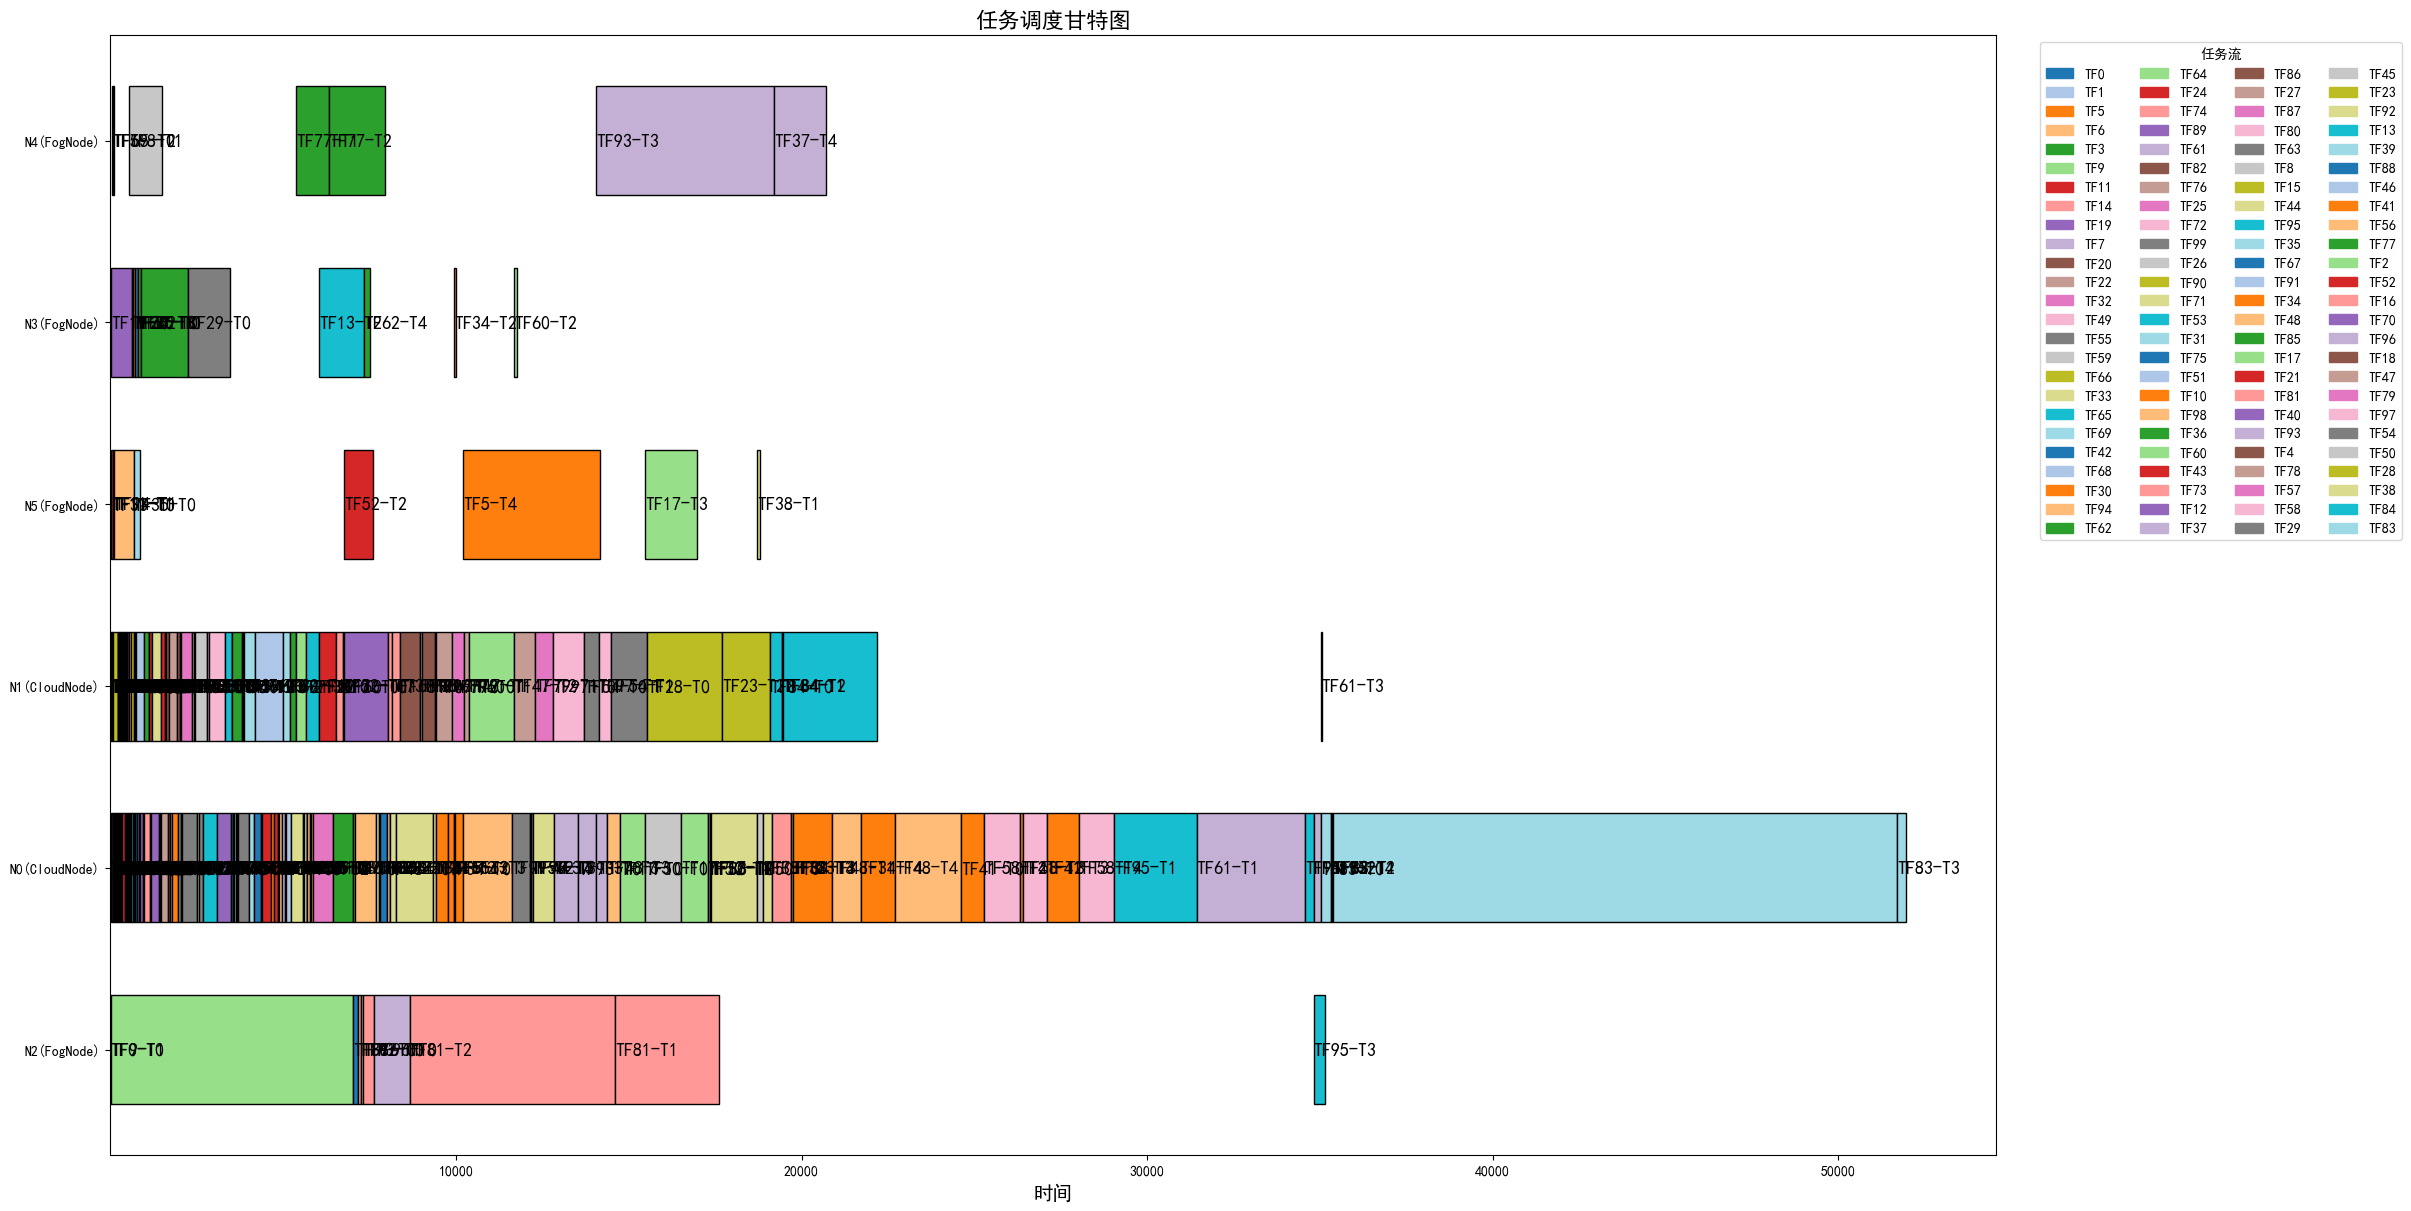

In [19]:
plot_gantt_from_log("./Results2/run_0/gen_50_log.json")

In [1]:
import json
import pandas as pd
import plotly.express as px

def plot_gantt_from_log_plotly(log_json_path, save_path=None):
    # 读取日志 JSON 文件
    with open(log_json_path, 'r', encoding='utf-8') as f:
        log_data = json.load(f)

    task_execution_log = log_data["task_execution_log"]

    df = pd.DataFrame([
        {
            "任务ID": record["task_id"],
            "开始时间": float(record["start_time"]),
            "持续时间": float(record["end_time"]) - float(record["start_time"]),
            "节点": record["node_id"],
            "任务流": f"TF{record['taskflow_id']}"
        }
        for record in task_execution_log
        if record["end_time"] is not None and record["end_time"] > record["start_time"]
    ])

    # 使用 px.bar 绘制水平条形图
    fig = px.bar(
        df,
        x="持续时间",
        y="节点",
        color="任务流",
        orientation="h",
        hover_name="任务ID",
        base="开始时间",
        title="任务调度甘特图"
    )

    fig.update_layout(
        font_family="SimHei",
        xaxis_title="时间",
        yaxis_title="节点",
        title_font_size=22,
        bargap=0.2,
        hovermode="x unified",
        plot_bgcolor="white",    # 图表绘图区背景色
        paper_bgcolor="white",   # 整张图背景色

    )

    # y轴翻转，使节点从上往下排列
    fig.update_yaxes(autorange="reversed")

    if save_path:
        fig.write_html(save_path)
    else:
        fig.show()


In [2]:
plot_gantt_from_log_plotly("./Results2/run_2/gen_50_log.json","taskschedule2.html")